# My first movie recommendation engine

## Recommendation engine from basic model to content-based recommender systems

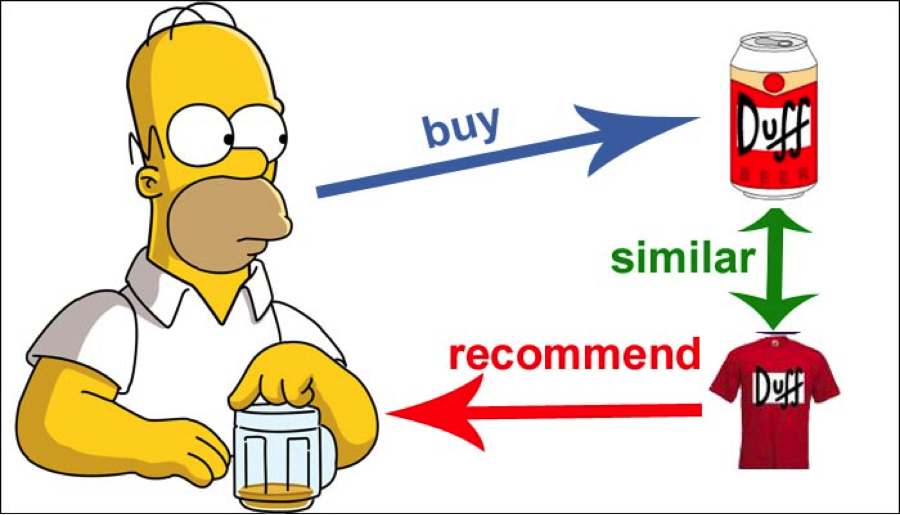

## Introduction 

Recommender systems are among the most popular applications of data science today. They are used to predict the "rating" or "preference" that a user would give to an item. Amazon uses it to suggest products to customers, YouTube uses it to decide which video to play next on autoplay, Facebook uses it to recommend pages to like and people to follow, and Netflix to recommend movies, etc.

Recommender systems can be classified into 3 types:
- **Simple recommenders:** offer generalized recommendations to every user, based on movie popularity and/or genre. The basic idea behind this system is that movies that are more popular and critically acclaimed will have a higher probability of being liked by the average audience.
- **Content-based recommenders:** suggest similar items based on a particular item. This system uses item metadata, if we take movies recommendations, it will use genre, director, description, actors, etc. The general idea behind these recommender systems is that if a person likes a particular item, he or she will also like an item that is similar to it. And to recommend that, it will make use of the user's past item metadata. A good example could be YouTube, where based on your history, it suggests you new videos that you could potentially watch.
- **Collaborative filtering engines:** these systems are widely used, and they try to predict the rating or preference that a user would give an item-based on past ratings and preferences of other users. Collaborative filters do not require item metadata like its content-based counterparts.

source : https://www.datacamp.com/community/tutorials/recommender-systems-python

# Import libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
import seaborn as sns
from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [2]:
pd.set_option("max_columns", None)
pd.set_option("max_colwidth", None)
pd.set_option("max_row", 500)

# Import Dataset

In [3]:
df = pd.read_csv( "movie_metadata.csv")

In [4]:
movies = df.copy()

# Exploratory Data Analysis 

In [5]:
#first rows visualization
movies.head(3)

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,plot_keywords,movie_imdb_link,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,CCH Pounder,Avatar,886204,4834,Wes Studi,0.0,avatar|future|marine|native|paraplegic,http://www.imdb.com/title/tt0499549/?ref_=fn_tt_tt_1,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,Johnny Depp,Pirates of the Caribbean: At World's End,471220,48350,Jack Davenport,0.0,goddess|marriage ceremony|marriage proposal|pirate|singapore,http://www.imdb.com/title/tt0449088/?ref_=fn_tt_tt_1,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,Christoph Waltz,Spectre,275868,11700,Stephanie Sigman,1.0,bomb|espionage|sequel|spy|terrorist,http://www.imdb.com/title/tt2379713/?ref_=fn_tt_tt_1,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000


In [6]:
#number of rows and features
movies.shape

(5043, 28)

In [7]:
# view features
movies.keys()

Index(['color', 'director_name', 'num_critic_for_reviews', 'duration',
       'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name',
       'actor_1_facebook_likes', 'gross', 'genres', 'actor_1_name',
       'movie_title', 'num_voted_users', 'cast_total_facebook_likes',
       'actor_3_name', 'facenumber_in_poster', 'plot_keywords',
       'movie_imdb_link', 'num_user_for_reviews', 'language', 'country',
       'content_rating', 'budget', 'title_year', 'actor_2_facebook_likes',
       'imdb_score', 'aspect_ratio', 'movie_facebook_likes'],
      dtype='object')

In [8]:
# summary of the dataframe
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   color                      5024 non-null   object 
 1   director_name              4939 non-null   object 
 2   num_critic_for_reviews     4993 non-null   float64
 3   duration                   5028 non-null   float64
 4   director_facebook_likes    4939 non-null   float64
 5   actor_3_facebook_likes     5020 non-null   float64
 6   actor_2_name               5030 non-null   object 
 7   actor_1_facebook_likes     5036 non-null   float64
 8   gross                      4159 non-null   float64
 9   genres                     5043 non-null   object 
 10  actor_1_name               5036 non-null   object 
 11  movie_title                5043 non-null   object 
 12  num_voted_users            5043 non-null   int64  
 13  cast_total_facebook_likes  5043 non-null   int64

In [9]:
movies.describe()

,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
count,4993.000000,5028.000000,4939.000000,5020.000000,5036.000000,4.159000e+03,5.043000e+03,5043.000000,5030.000000,5022.000000,4.551000e+03,4935.000000,5030.000000,5043.000000,4714.000000,5043.000000
mean,140.194272,107.201074,686.509212,645.009761,6560.047061,4.846841e+07,8.366816e+04,9699.063851,1.371173,272.770808,3.975262e+07,2002.470517,1651.754473,6.442138,2.220403,7525.964505
std,121.601675,25.197441,2813.328607,1665.041728,15020.759120,6.845299e+07,1.384853e+05,18163.799124,2.013576,377.982886,2.061149e+08,12.474599,4042.438863,1.125116,1.385113,19320.445110
min,1.000000,7.000000,0.000000,0.000000,0.000000,1.620000e+02,5.000000e+00,0.000000,0.000000,1.000000,2.180000e+02,1916.000000,0.000000,1.600000,1.180000,0.000000
25%,50.000000,93.000000,7.000000,133.000000,614.000000,5.340988e+06,8.593500e+03,1411.000000,0.000000,65.000000,6.000000e+06,1999.000000,281.000000,5.800000,1.850000,0.000000
50%,110.000000,103.000000,49.000000,371.500000,988.000000,2.551750e+07,3.435900e+04,3090.000000,1.000000,156.000000,2.000000e+07,2005.000000,595.000000,6.600000,2.350000,166.000000
75%,195.000000,118.000000,194.500000,636.000000,11000.000000,6.230944e+07,9.630900e+04,13756.500000,2.000000,326.000000,4.500000e+07,2011.000000,918.000000,7.200000,2.350000,3000.000000
max,813.000000,511.000000,23000.000000,23000.000000,640000.000000,7.605058e+08,1.689764e+06,656730.000000,43.000000,5060.000000,1.221550e+10,2016.000000,137000.000000,9.500000,16.000000,349000.000000


In [10]:
# checking the null values
movies.isnull().sum(axis=0)

color                         19
director_name                104
num_critic_for_reviews        50
duration                      15
director_facebook_likes      104
actor_3_facebook_likes        23
actor_2_name                  13
actor_1_facebook_likes         7
gross                        884
genres                         0
actor_1_name                   7
movie_title                    0
num_voted_users                0
cast_total_facebook_likes      0
actor_3_name                  23
facenumber_in_poster          13
plot_keywords                153
movie_imdb_link                0
num_user_for_reviews          21
language                      12
country                        5
content_rating               303
budget                       492
title_year                   108
actor_2_facebook_likes        13
imdb_score                     0
aspect_ratio                 329
movie_facebook_likes           0
dtype: int64

<AxesSubplot:>

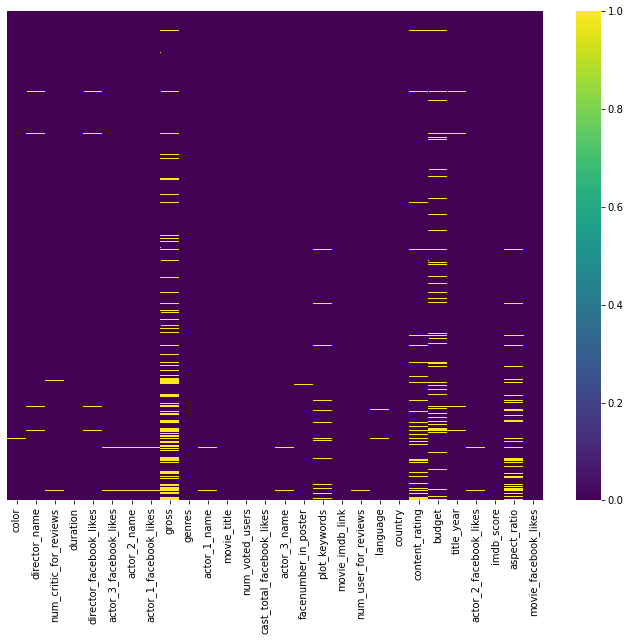

In [11]:
# NaN visualisation (in yellow)
fig,ax=plt.subplots()
fig.set_size_inches(12,9)
sns.heatmap(movies.isnull(),yticklabels=False,cmap='viridis',ax=ax)

# 1. Simple Recommender system

### 1.1 Needed features 

In [12]:
movies['num_user_for_reviews']

0       3054.0
1       1238.0
2        994.0
3       2701.0
4          NaN
         ...  
5038       6.0
5039     359.0
5040       3.0
5041       9.0
5042      84.0
Name: num_user_for_reviews, Length: 5043, dtype: float64

In [13]:
movies['imdb_score']

0       7.9
1       7.1
2       6.8
3       8.5
4       7.1
       ... 
5038    7.7
5039    7.5
5040    6.3
5041    6.3
5042    6.6
Name: imdb_score, Length: 5043, dtype: float64

In [14]:
movies['movie_title']

0                                                       Avatar 
1                     Pirates of the Caribbean: At World's End 
2                                                      Spectre 
3                                        The Dark Knight Rises 
4       Star Wars: Episode VII - The Force Awakens             
                                 ...                           
5038                                   Signed Sealed Delivered 
5039                                 The Following             
5040                                      A Plague So Pleasant 
5041                                          Shanghai Calling 
5042                                         My Date with Drew 
Name: movie_title, Length: 5043, dtype: object

### 1.2 Decide on the metric or score to rate movies on.

In [15]:
# Calculate mean (C) of imdb_score column
C = movies['imdb_score'].mean()
print(C)

6.442137616498111


The average rating of a movie on IMDB is around 6.4 on a scale of 10.

In [16]:
# Calculate the minimum (m) number of user for reviews required to be in the chart, m
m = movies['num_user_for_reviews'].quantile(0.90)
print(m)

630.0


In [17]:
# Filter out all qualified (q) movies into a new DataFrame
q_movies = movies.copy().loc[movies['num_user_for_reviews'] >= m]
q_movies.shape

(504, 28)

###  1.3 Calculate the score for every movie

In [18]:
# Function that computes the weighted rating of each movie
def weighted_rating(x, m=m, C=C):
    v = x['num_user_for_reviews']
    S = x['imdb_score']
    # Calculation based on the IMDB formula
    return (v/(v+m) * S) + (m/(m+v) * C)

In [19]:
# Define a new feature 'score' and calculate its value with `weighted_rating()`
q_movies['score'] = q_movies.apply(weighted_rating, axis=1)

### 1.4 Sort the movies based on the score and output the top results 

In [20]:
#Sort movies based on score calculated above
q_movies = q_movies.sort_values('score', ascending=False)

#Print the top 15 movies
q_movies[['movie_title', 'num_user_for_reviews', 'imdb_score', 'score']].head(15)

,movie_title,num_user_for_reviews,imdb_score,score
1937,The Shawshank Redemption,4144.0,9.3,8.922863
66,The Dark Knight,4667.0,9.0,8.695780
3466,The Godfather,2238.0,9.2,8.594193
270,The Lord of the Rings: The Fellowship of the Ring,5060.0,8.8,8.538936
339,The Lord of the Rings: The Return of the King,3189.0,8.9,8.494540
683,Fight Club,2968.0,8.8,8.387145
654,The Matrix,3646.0,8.7,8.367340
97,Inception,2803.0,8.8,8.367302
3355,Pulp Fiction,2195.0,8.9,8.351875
340,The Lord of the Rings: The Two Towers,2417.0,8.7,8.233163


# 2. Content-based recommenders system

## 2.1 Recommendation based on genres

### Data pre-processing

In [21]:
#Print plot overviews of the first 5 movies.
movies['genres'].head()

0    Action|Adventure|Fantasy|Sci-Fi
1           Action|Adventure|Fantasy
2          Action|Adventure|Thriller
3                    Action|Thriller
4                        Documentary
Name: genres, dtype: object

In [22]:
# function to split string into words 
def genre_split(string):
    # Split the string into words
    words = string.split('|')
    result = ' '.join(words)
    
    # Return the number of words
    return result

In [23]:
movies.genres = movies.genres.apply(genre_split)

In [24]:
#movie genres columns after replacing the ‘|’ with whitespace, so the genres would be considered different strings
movies['genres']

0       Action Adventure Fantasy Sci-Fi
1              Action Adventure Fantasy
2             Action Adventure Thriller
3                       Action Thriller
4                           Documentary
                     ...               
5038                       Comedy Drama
5039       Crime Drama Mystery Thriller
5040              Drama Horror Thriller
5041               Comedy Drama Romance
5042                        Documentary
Name: genres, Length: 5043, dtype: object

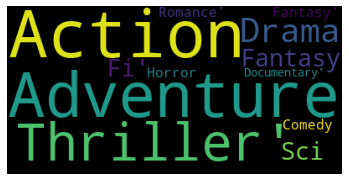

In [25]:
# view summary of genres:
text = movies['genres'].values 

wordcloud = WordCloud().generate(str(text))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

#### Calculate the TF-IDF and similarity scores 

In [26]:
#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(lowercase=True, stop_words='english')

#Replace NaN with an empty string
movies['genres'] = movies['genres'].fillna('')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(movies['genres'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

(5043, 29)

In [27]:
# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim.shape

(5043, 5043)

In [28]:
cosine_sim[1]

array([0.7385333 , 1.        , 0.64735408, ..., 0.        , 0.        ,
       0.        ])

In [29]:
movies['movie_title']=='Avatar\xa0'

0        True
1       False
2       False
3       False
4       False
        ...  
5038    False
5039    False
5040    False
5041    False
5042    False
Name: movie_title, Length: 5043, dtype: bool

In [30]:
# \xa0 is actually non-breaking space in Latin1 (ISO 8859-1), also chr(160). You should replace it with a space.
movies['movie_title'] = movies['movie_title'].str[:-1]

In [31]:
# convert title to lower case
movies['movie_title'] = movies['movie_title'].str.lower() 

In [32]:
#Construct a reverse map of indices and movie titles
indices = pd.Series(movies.index, index=movies['movie_title']).drop_duplicates()

In [33]:
indices[:10]

movie_title
avatar                                                    0
pirates of the caribbean: at world's end                  1
spectre                                                   2
the dark knight rises                                     3
star wars: episode vii - the force awakens                4
john carter                                               5
spider-man 3                                              6
tangled                                                   7
avengers: age of ultron                                   8
harry potter and the half-blood prince                    9
dtype: int64

In [34]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the (5) most similar movies
    sim_scores = sim_scores[1:6]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 5 most similar movies
    return movies['movie_title'].iloc[movie_indices]

### Top 5  of our recommended movies based on genres similarity

In [35]:
print(get_recommendations('toy story'))

43             toy story 3
55       the good dinosaur
56                   brave
87     shrek forever after
107        shrek the third
Name: movie_title, dtype: object


In [36]:
print(get_recommendations('american pie'))

331            the campaign
440    the hangover part ii
449             grown ups 2
514           jack and jill
535               grown ups
Name: movie_title, dtype: object


In [37]:
print(get_recommendations('pretty woman'))

293     little fockers
408        the holiday
458    just go with it
530     50 first dates
584      runaway bride
Name: movie_title, dtype: object


In [38]:
print(get_recommendations('avatar'))

15                                     man of steel
39                         the amazing spider-man 2
236    star wars: episode iii - revenge of the sith
237    star wars: episode ii - attack of the clones
240       star wars: episode i - the phantom menace
Name: movie_title, dtype: object


**CONCLUSION**: the recommendation works pretty well when it's based on genre 

## 2.2 Recommendation based on director

In [39]:
#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(lowercase=True, stop_words='english')

#Replace NaN with an empty string
movies['director_name'] = movies['director_name'].fillna('')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix_director = tfidf.fit_transform(movies['director_name'])

#Output the shape of tfidf_matrix
tfidf_matrix_director.shape

(5043, 2945)

In [40]:
cosine_sim_director = linear_kernel(tfidf_matrix_director, tfidf_matrix_director)
cosine_sim_director.shape

(5043, 5043)

In [41]:
# another way

# replace Nan with unknown
# movies['director_name'] = movies['director_name'].replace(np.nan,'unknown')

# creating a count matrix now
#cv = CountVectorizer()
#count_matrix = cv.fit_transform(movies['director_name'])
#similarity score matrix
#sim_director = cosine_similarity(count_matrix)

In [42]:
# Function that takes in movie title as input and outputs most similar movies
def recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim_director[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the (5) most similar movies
    sim_scores = sim_scores[1:6]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 5 most similar movies
    return movies['movie_title'].iloc[movie_indices]

### Top 5  of our recommended movies based on director similarity

In [43]:
print(recommendations('toy story'))

353            toy story 2
583                   cars
1095          a bug's life
1588             toy story
2892    operation chromite
Name: movie_title, dtype: object


In [44]:
print(recommendations('man of steel'))

15                                      man of steel
165                                         watchmen
312    legend of the guardians: the owls of ga'hoole
564                                     sucker punch
709                                              300
Name: movie_title, dtype: object


In [45]:
print(recommendations('titanic'))

26                         titanic
288     terminator 2: judgment day
291                      true lies
606                      the abyss
2486                        aliens
Name: movie_title, dtype: object


In [46]:
print(movies.iloc[15,1])
print(movies.iloc[165,1])

Zack Snyder
Zack Snyder


**CONCLUSION**: the recommendation based on director works as well as on genres

In [47]:
#Replace NaN with an empty string
movies['actor_1_name'] = movies['actor_1_name'].fillna('')
movies['actor_2_name'] = movies['actor_2_name'].fillna('')
movies['actor_3_name'] = movies['actor_3_name'].fillna('')

In [48]:
tfidf_matrix_actor_1 = tfidf.fit_transform(movies['actor_1_name'])
tfidf_matrix_actor_1.shape

(5043, 2876)

In [49]:
cosine_sim_actor_1 = linear_kernel(tfidf_matrix_actor_1, tfidf_matrix_actor_1)
cosine_sim_actor_1.shape

(5043, 5043)

In [50]:
def recommendations_by_actor(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim_actor_1[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the (5) most similar movies
    sim_scores = sim_scores[1:6]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 5 most similar movies
    return movies['movie_title'].iloc[movie_indices]

In [51]:
movies['actor_1_name']

0           CCH Pounder
1           Johnny Depp
2       Christoph Waltz
3             Tom Hardy
4           Doug Walker
             ...       
5038        Eric Mabius
5039        Natalie Zea
5040        Eva Boehnke
5041          Alan Ruck
5042        John August
Name: actor_1_name, Length: 5043, dtype: object

In [52]:
print(recommendations_by_actor('man of steel'))

15                   man of steel
548       the man from u.n.c.l.e.
554                     immortals
610                      stardust
1230    the count of monte cristo
Name: movie_title, dtype: object


In [53]:
print(movies.iloc[15,10])
print(movies.iloc[610,10])
print(movies.iloc[548,10])
print(movies.iloc[1230,10])

Henry Cavill
Henry Cavill
Henry Cavill
Henry Cavill


#### New dataset with needed labels 

In [54]:
new_movies = movies[['director_name','actor_2_name','genres','title_year','actor_1_name','movie_title','actor_3_name']]
new_movies.head(10)

,director_name,actor_2_name,genres,title_year,actor_1_name,movie_title,actor_3_name
0,James Cameron,Joel David Moore,Action Adventure Fantasy Sci-Fi,2009.0,CCH Pounder,avatar,Wes Studi
1,Gore Verbinski,Orlando Bloom,Action Adventure Fantasy,2007.0,Johnny Depp,pirates of the caribbean: at world's end,Jack Davenport
2,Sam Mendes,Rory Kinnear,Action Adventure Thriller,2015.0,Christoph Waltz,spectre,Stephanie Sigman
3,Christopher Nolan,Christian Bale,Action Thriller,2012.0,Tom Hardy,the dark knight rises,Joseph Gordon-Levitt
4,Doug Walker,Rob Walker,Documentary,NaN,Doug Walker,star wars: episode vii - the force awakens,
5,Andrew Stanton,Samantha Morton,Action Adventure Sci-Fi,2012.0,Daryl Sabara,john carter,Polly Walker
6,Sam Raimi,James Franco,Action Adventure Romance,2007.0,J.K. Simmons,spider-man 3,Kirsten Dunst
7,Nathan Greno,Donna Murphy,Adventure Animation Comedy Family Fantasy Musical Romance,2010.0,Brad Garrett,tangled,M.C. Gainey
8,Joss Whedon,Robert Downey Jr.,Action Adventure Sci-Fi,2015.0,Chris Hemsworth,avengers: age of ultron,Scarlett Johansson
9,David Yates,Daniel Radcliffe,Adventure Family Fantasy Mystery,2009.0,Alan Rickman,harry potter and the half-blood prince,Rupert Grint


In [55]:
new_movies['genres']

0       Action Adventure Fantasy Sci-Fi
1              Action Adventure Fantasy
2             Action Adventure Thriller
3                       Action Thriller
4                           Documentary
                     ...               
5038                       Comedy Drama
5039       Crime Drama Mystery Thriller
5040              Drama Horror Thriller
5041               Comedy Drama Romance
5042                        Documentary
Name: genres, Length: 5043, dtype: object

In [56]:
new_movies['director_genre_actors'] = new_movies['director_name']+' '+new_movies['actor_1_name']+' '+' '+new_movies['actor_2_name']+' '+new_movies['actor_3_name']+' '+new_movies['genres']

c:\Users\utilisateur\anaconda3\envs\Simplon\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [57]:
new_movies.head()

,director_name,actor_2_name,genres,title_year,actor_1_name,movie_title,actor_3_name,director_genre_actors
0,James Cameron,Joel David Moore,Action Adventure Fantasy Sci-Fi,2009.0,CCH Pounder,avatar,Wes Studi,James Cameron CCH Pounder Joel David Moore Wes Studi Action Adventure Fantasy Sci-Fi
1,Gore Verbinski,Orlando Bloom,Action Adventure Fantasy,2007.0,Johnny Depp,pirates of the caribbean: at world's end,Jack Davenport,Gore Verbinski Johnny Depp Orlando Bloom Jack Davenport Action Adventure Fantasy
2,Sam Mendes,Rory Kinnear,Action Adventure Thriller,2015.0,Christoph Waltz,spectre,Stephanie Sigman,Sam Mendes Christoph Waltz Rory Kinnear Stephanie Sigman Action Adventure Thriller
3,Christopher Nolan,Christian Bale,Action Thriller,2012.0,Tom Hardy,the dark knight rises,Joseph Gordon-Levitt,Christopher Nolan Tom Hardy Christian Bale Joseph Gordon-Levitt Action Thriller
4,Doug Walker,Rob Walker,Documentary,NaN,Doug Walker,star wars: episode vii - the force awakens,,Doug Walker Doug Walker Rob Walker Documentary


In [58]:
#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(lowercase=True, stop_words='english')

#Replace NaN with an empty string
new_movies['director_genre_actors'] = new_movies['director_genre_actors'].fillna('')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix_all = tfidf.fit_transform(new_movies['director_genre_actors'])

#Output the shape of tfidf_matrix
tfidf_matrix_all.shape

c:\Users\utilisateur\anaconda3\envs\Simplon\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


(5043, 8587)

In [59]:
#Importer TfidfVectorizer depuis sklearn.
from sklearn.feature_extraction.text import TfidfVectorizer


#Créer un objet TfidfVectorizer. Nommez-le vectorizer.
vectorizer = TfidfVectorizer()


#Générer tfidf_matrix pour ted en utilisant la méthode fit_transform ()
tfidf_matrix_all = vectorizer.fit_transform(new_movies['director_genre_actors'])


# afficher la taille de tfidf_matrix
print(tfidf_matrix_all.shape)

(5043, 8600)


In [60]:
cosine_sim_all = linear_kernel(tfidf_matrix_all, tfidf_matrix_all)
cosine_sim_all.shape
# store its reference in the variable file1  
# and "MyFile2.txt" in D:\Text in file2
import pickle
file = "cosin_sim_model.sav"
pickle.dump(cosine_sim_all, open(file, "wb"))


In [61]:
# store its reference in the variable file1  
# and "MyFile2.txt" in D:\Text in file2
import pickle
file = "cosin_sim_model.sav"
pickle.dump(cosine_sim_all, open(file, "wb"))


In [62]:
def recommendations_from_all(movie):
    if movie not in new_movies['movie_title'].unique():
        return('Movie not found')
    else:
        i = new_movies.loc[new_movies['movie_title']==movie].index[0]
        simScores = list(enumerate(cosine_sim_all[i]))
        simScores = sorted(simScores, key = lambda x:x[1] ,reverse=True)
        simScores = simScores[1:6] # excluding first item since it is the requested movie itself
        titles = []
        years=[]
        for i in range(len(simScores)):
            a = simScores[i][0]
            titles.append(new_movies['movie_title'][a])
            years.append(new_movies['title_year'][a])
            
            
        plt.figure(figsize=(10,5))
        plt.bar(titles, [i[1] for i in simScores])
        plt.xticks(rotation=90)
        plt.xlabel('Movies similar to → '+movie, fontsize=12,fontweight="bold")
        plt.ylabel('cosine scores', fontsize=12,fontweight="bold")
        plt.show()
        df_results = pd.DataFrame({'Movies Recommended':titles, 'Year':years, 'scores':simScores})
        print(df_results['scores'][0][1])


        df_results.drop_duplicates
        return df_results

In [63]:
# cos_sim_df = pd.DataFrame(cosine_sim, index=indices, columns=indices)
# cos_sim_df.to_csv("movies_similarities.csv")

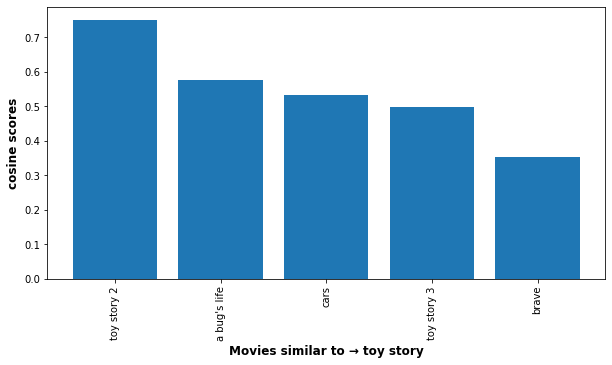

0.7507530978470962


,Movies Recommended,Year,scores
0,toy story 2,1999.0,"(353, 0.7507530978470962)"
1,a bug's life,1998.0,"(1095, 0.5771270513217508)"
2,cars,2006.0,"(583, 0.5316647360358642)"
3,toy story 3,2010.0,"(43, 0.4972208741841876)"
4,brave,2012.0,"(56, 0.35405494716300384)"


In [64]:
recommendations_from_all('toy story')

In [67]:
recommendations_from_all('james cameron')

'Movie not found'

***To be continued...***